In [31]:
import numpy as np
import torch
import torchdiffeq
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

In [32]:
def load_setup(toy_example=False, p=None):
    if toy_example:
        c = torch.load('data/c.pt', weights_only=True)
        d = torch.load('data/d.pt', weights_only=True)
        A = torch.load('data/A.pt', weights_only=True)
        H = torch.load('data/H.pt', weights_only=True)

        dimX = (A.shape[0], 1);dimY = (A.shape[1], 1);

        def f(x, y):
            x = x.reshape(dimX); y = y.reshape(dimY)
            return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

        def g(x, y):
            x = x.reshape(dimX); y = y.reshape(dimY)
            return 0.5 * torch.linalg.norm(H@y - x)**2
        
        print('dim X:', dimX, 'dim Y:' ,dimY)
        return f, g, c, d, A, H, dimX, dimY
    
    else:
        string = 'p' + str(p)
        A_tr = torch.load('data/A_tr' + string + '.pt', weights_only=True).to(torch.float32)
        B_tr = torch.load('data/B_tr' + string + '.pt', weights_only=True).to(torch.float32)
        
        A_val = torch.load('data/A_val' + string + '.pt', weights_only=True).to(torch.float32)
        B_val = torch.load('data/B_val' + string + '.pt', weights_only=True).to(torch.float32)

        A_test = torch.load('data/A_test' + string + '.pt', weights_only=True).to(torch.float32)
        B_test = torch.load('data/B_test' + string + '.pt', weights_only=True).to(torch.float32)

        lam = 0.001      # Regularization parameter
        dimX = (A_tr.shape[0], 1); dimY = (A_tr.shape[1], B_tr.shape[1]);

        def f(x, y):
            x = x.reshape(dimX); y = y.reshape(dimY)
            loss = F.cross_entropy(A_val @ y, B_val)
            return loss

        def g(x, y):
            x = x.reshape(dimX); y = y.reshape(dimY)
            loss = F.cross_entropy(A_tr @ y, B_tr, reduction='none')
            return torch.mean(torch.mul(loss, torch.sigmoid(x))) + lam * torch.pow(torch.norm(y, 'fro'), 2)

        print('dim X:', dimX, 'dim Y:' ,dimY)
        return f, g, A_tr, B_tr, A_val, B_val, A_test, B_test, dimX, dimY

In [33]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((sizeY, sizeY))
    dgdyx = torch.zeros((sizeY, sizeX))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

def calc_derivatives_analytic(x, y):
    if toy_example:
        dfdx = torch.cos(c.T @ x + d.T @ y) * c + 2 *(x+y) / (torch.linalg.norm(x+y)**2 + 1)
        dfdy = torch.cos(c.T @ x + d.T @ y) * d + 2 * (x+y) / (torch.linalg.norm(x+y)**2 + 1)

        dgdx = - (H @ y - x)
        dgdy = H.T @ (H @ y - x)

        dgdyy = H.T @ H
        dgdyx = -H
    else:
        x = x.reshape(dimX); y = y.reshape(dimY)
        logits_val = A_val @ y
        logist_tr = A_tr @ y

        dfdx  = torch.zeros_like(x)
        dfdy = 1 / B_val.shape[0] * (A_val.T @ (torch.softmax(logits_val, dim=1) - B_val)).reshape(-1, 1)

        loss = F.cross_entropy(logist_tr, B_tr)
        sigmoid_x = torch.sigmoid(x)
        softmax_y = torch.softmax(logist_tr, dim=1)
        
        dgdx = 1 / B_tr.shape[0] * loss * sigmoid_x * (1 - sigmoid_x)
        # dgdy =  (1 / n_train * A_tr.T @ ((softmax_y - B_tr) * sigmoid_x) + 2 * lam * y).reshape(-1, 1)

        dgdyx = 1 / B_tr.shape[0]**2 * (sigmoid_x * (1 - sigmoid_x)).T * (A_tr.T @ (softmax_y - B_tr)).reshape(-1, 1)
        # dgdyy = 1 / n_train * A_tr.T @ (softmax_y * (1 - softmax_y) * A_tr) \
        #             + 2 * lam * torch.eye(sizeY)
        y = y.reshape((sizeY, 1))
        g_val = g(x, y)
        dgdy = torch.autograd.grad(g_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
        dgdyy = torch.zeros((sizeY, sizeY))
        # print(dgdy[0].shape, y.shape)
        for i in range(dgdy.shape[0]):
            dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True,
                                               allow_unused=True, materialize_grads=True)[0][:, 0]
        
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx
# now = time.time()
# dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
# print('Time elapsed:', time.time() - now)
# now = time.time()
# dfdx2, dfdy2, dgdx2, dgdy2, dgdyy2, dgdyx2 = calc_derivatives_analytic(x, y)
# print('Time elapsed:', time.time() - now)

# assert torch.allclose(dfdx, dfdx2)
# assert torch.allclose(dfdy, dfdy2)
# assert torch.allclose(dgdx, dgdx2)
# assert torch.allclose(dgdy, dgdy2, atol=1e-2)
# assert torch.allclose(dgdyx, dgdyx2)
# assert torch.allclose(dgdyy, dgdyy2)

In [34]:
def solveLL(x):
    t0 = time.time()
    y = torch.randn((sizeY, 1), requires_grad=True, dtype=torch.float32)
    lr = 1e-1
    while True:
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        with torch.no_grad():
            HessianInv = dgdyy.inverse()
            y -= lr * HessianInv @ dgdy
            if torch.linalg.norm(dgdy, 2) < 1e-3:
                break

    print('LL error: ', torch.linalg.norm(dgdy, 2), 'Time elapsed:', time.time() - t0)
    return y, dgdy


# Define the system of ODEs
def system(t, variables):
    x, y = variables[:sizeX], variables[sizeX:]
    global dxdt #Because its previous value is required in ProjectMethod 1
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if method == 'InversionFree':
            a = 2 * dgdyx.T @ dgdy
            b = 2 * dgdyy @ dgdy
            c = -alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
            ab = torch.cat((a, b), 0)

            tot = torch.cat((dfdx, dfdy), 0)
            d = ab * torch.maximum(torch.Tensor([0]), -ab.T @ tot - c) / (torch.linalg.norm(a, 2)**2 + torch.linalg.norm(b, 2)**2)
            dtotdt = -tot - d
            dxdt = dtotdt[:sizeX]; dydt = dtotdt[sizeX:]
            
            if torch.linalg.norm(dgdy, 2) > epsilon and not torch.allclose(torch.linalg.norm(dgdy, 2), torch.Tensor([epsilon])):
                print('t=',t, '-', torch.linalg.norm(dgdy, 2), epsilon)
        #  
        elif method == 'NewSecondOrder':
            a = dgdyx @ dgdyx.T
            b = dgdyy @ dgdyy.T
            c = -alpha * dgdy + dgdyx @ dfdx + dgdyy @ dfdy
            lam = -torch.inverse(a + b) @ c

            dxdt = -dfdx - dgdyx.T @ lam
            dydt = -dfdy - dgdyy.T @ lam

        elif method == 'SecondOrder':
            mu = 0.05
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (mu * dgdy + dgdyx @ dxdt)  
        # 
        elif method == 'STABLE':
            mu1 = 1
            mu2 = 0.5
            gHessianInv = dgdyy.inverse()
            dxdt = mu1 * (-dfdx + dgdyx.T @ gHessianInv @ dfdy)
            dydt = -mu2 * dgdy - gHessianInv @ dgdyx @ dxdt 
        
        else:
            raise ValueError('Invalid method')
    
    return torch.cat((dxdt, dydt), 0)

In [35]:
def calculate_accuracy(A, B, W):
    W = W.reshape(dimY, -1)  # Reshape W to be of shape (num_classes, num_features)
    predictions = A @ W  # (n_samples, num_classes)
    predicted_labels = torch.argmax(predictions, dim=1)
    true_labels = torch.argmax(B, dim=1)  # Convert one-hot to class indices
    correct_predictions = (predicted_labels == true_labels).float().sum()
    return correct_predictions / B.size(0)

# Helper function to calculate loss
def calculate_loss(A, B, W):
    W = W.reshape(dimY, -1)  # Reshape W to be of shape (num_classes, num_features)
    logits = A @ W  # (n_samples, num_classes)
    true_labels = torch.argmax(B, dim=1)  # Convert one-hot to class indices
    loss = torch.nn.functional.cross_entropy(logits, true_labels, reduction='mean')
    return loss.unsqueeze(0).unsqueeze(0)


In [36]:
# def helper(x, y0, K, alpha):
#     for k in range(K):
#         dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y0)
#         # print(y.shape, y[0].shape, dgdy.shape)
#         y0 = y0 - alpha * dgdy
#     return f(x, y0)

# def AIDBio(x, y0, alpha=0.01, beta=0.01, K=10, D=10):
#     y = y0
#     solution2 = [torch.cat((x, y), 0)]
#     for k in range(K):
#         yinit = y
#         for t in range(D):
#             dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
#             y = y - alpha * dgdy
#             solution2.append(torch.cat((x, y), 0))
#         x = x - beta * torch.autograd.grad(helper(x, yinit, K=K, alpha=alpha), x, retain_graph=True, create_graph=True,
#                                                allow_unused=True, materialize_grads=True)[0]
#         solution2.append(torch.cat((x, y), 0))
#     return torch.stack(solution2)  



In [37]:
def calculate_losses(sol):
    # Calculate lossf directly as a tensor, avoid unnecessary reshaping
    lossf = f(sol[:sizeX], sol[sizeX:]).reshape(-1, )

    # Calculate derivatives
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(sol[:sizeX], sol[sizeX:])

    # Compute norms as tensors
    lossG = torch.linalg.norm(dgdy)
    lossF = torch.linalg.norm(dfdx - dgdyx.T @ dgdyy.inverse() @ dfdy)
    # Detach and convert to NumPy arrays for storage
    return (
        lossf.detach().numpy(), 
        lossG.detach().numpy(), 
        lossF.detach().numpy()
    )

def conjugate_gradient(A, b, x0, N):
    r = b - np.dot(A, x0)
    p = r.copy()
    x = x0.copy()
    rs_old = np.dot(r.T, r)

    for i in range(N):
        Ap = np.dot(A, p)
        alpha = rs_old / np.dot(p.T, Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = np.dot(r.T, r)
        if np.sqrt(rs_new) < 1e-10:  # Convergence criterion
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return torch.Tensor(x)


def TTSA(x, y, alpha=0.1, beta=0.1, K=100):
    lossF, lossG, lossF2 = [], [], []
    train_accuracy, val_accuracy, test_accuracy = [], [], []
    train_loss, val_loss, test_loss = [], [], []

    for k in range(K):
        # Calculate derivatives for current x and y
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)

        # Update y
        y = y - beta / (1+k)**(3/5) * dgdy

        # Recalculate derivatives after updating y
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)

        # Update x
        x = x - alpha / (1+k)**(2/5) * (dfdx - dgdyx.T @ dgdyy.inverse() @ dfdy)

        # Compute and store losses (no gradient tracking)
        term1, term2, term3 = calculate_losses(torch.cat((x, y), 0))
        lossF.append(term1); lossG.append(term2); lossF2.append(term3)
        if not toy_example:
            W = y
            train_accuracy.append(calculate_accuracy(A_tr, B_tr, W))
            train_loss.append(calculate_loss(A_tr, B_tr, W))
            val_accuracy.append(calculate_accuracy(A_val, B_val, W))
            val_loss.append(calculate_loss(A_val, B_val, W))
            test_accuracy.append(calculate_accuracy(A_test, B_test, W))
            test_loss.append(calculate_loss(A_test, B_test, W))

    # Convert lists of losses to tensors for easy analysis
    return np.array(lossF), np.array(lossG), np.array(lossF2), (train_accuracy, val_accuracy, test_accuracy), (train_loss, val_loss, test_loss)

def AITBio(x, y0, alpha=0.01, beta=0.01, K=10, D=10):
    y = y0
    lossF, lossG, lossF2 = [], [], []
    train_accuracy, val_accuracy, test_accuracy = [], [], []
    train_loss, val_loss, test_loss = [], [], []
    nu = torch.zeros_like(y0)
    for k in range(K):
        for t in range(D):
            dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
            y = y - alpha * dgdy
            
            term1, term2, term3 = calculate_losses(torch.cat((x, y), 0))
            lossF.append(term1); lossG.append(term2); lossF2.append(term3)

        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        if False:
            nu =  dgdyy.inverse() @ dfdy
        else:
            nu = conjugate_gradient(dgdyy.detach().numpy(), dfdy.detach().numpy(), nu.detach().numpy(), 10)
        x = x - beta * (dfdx - dgdyx.T @ nu)
        
        term1, term2, term3 = calculate_losses(torch.cat((x, y), 0))
        lossF.append(term1); lossG.append(term2); lossF2.append(term3)
        if not toy_example:
            W = y
            train_accuracy.append(calculate_accuracy(A_tr, B_tr, W))
            train_loss.append(calculate_loss(A_tr, B_tr, W))
            val_accuracy.append(calculate_accuracy(A_val, B_val, W))
            val_loss.append(calculate_loss(A_val, B_val, W))
            test_accuracy.append(calculate_accuracy(A_test, B_test, W))
            test_loss.append(calculate_loss(A_test, B_test, W))
        
    return np.array(lossF), np.array(lossG), np.array(lossF2), (train_accuracy, val_accuracy, test_accuracy), (train_loss, val_loss, test_loss)
# def AIDBio(x, y0, alpha=0.1, beta=0.01, K=10, D=10):
#     y = y0
#     lossF, lossG, lossF2 = [], [], []
#     for k in range(K):
#         term = 0
#         termxy = []
#         termyy = []
#         for t in range(D):
#             dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
#             termxy.append(dgdyx)
#             termyy.append(torch.eye(sizeY) - alpha * dgdyy)
#             y = y - alpha * dgdy
            
#             term1, term2, term3 = calculate_losses(torch.cat((x, y), 0))
#             lossF.append(term1); lossG.append(term2); lossF2.append(term3)

#         for t in range(D):
#             tmp = torch.eye(sizeY)
#             for j in range(t+1, D):
#                 tmp = termyy[j] @ tmp
#             term += termxy[t].T @ tmp
#         dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
#         x = x - beta * (dfdx - alpha * term @ dfdy)
        
#         term1, term2, term3 = calculate_losses(torch.cat((x, y), 0))
#         lossF.append(term1); lossG.append(term2); lossF2.append(term3)
        
#     return np.array(lossF), np.array(lossG), np.array(lossF2)

dim X: (5000, 1) dim Y: (82, 10)
-- Method: AITBio Alpha: 0.1 Epsilon: 0.1
dim X: (5000, 1) dim Y: (82, 10)
Time taken: 10.575620889663696 

Train Accuracy: 0.09560000151395798 Validation Accuracy: 0.08959999680519104 Test Accuracy: 0.10480000078678131
-- Method: InversionFree Alpha: 0.1 Epsilon: 0.1


/home/sina/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


dim X: (5000, 1) dim Y: (82, 10)
Time taken: 0.6423683166503906 

Train Accuracy: 0.0997999981045723 Validation Accuracy: 0.06759999692440033 Test Accuracy: 0.06319999694824219


/home/sina/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


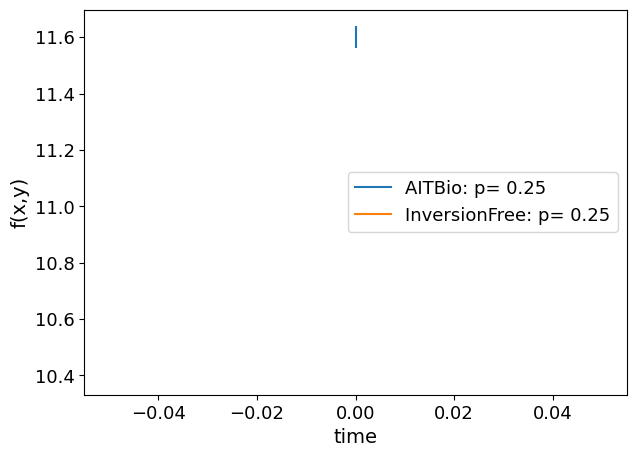

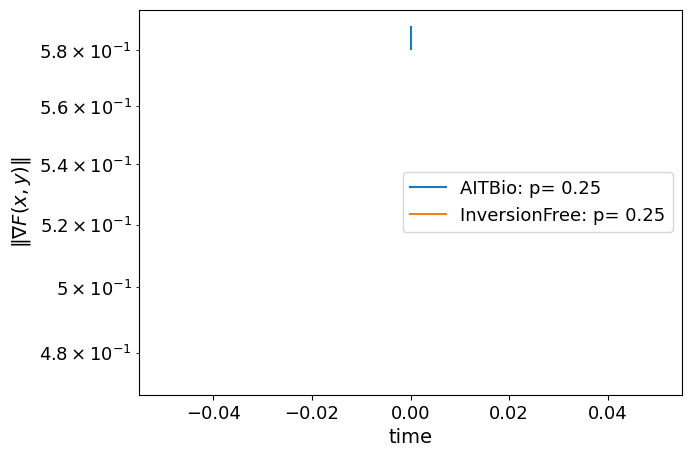

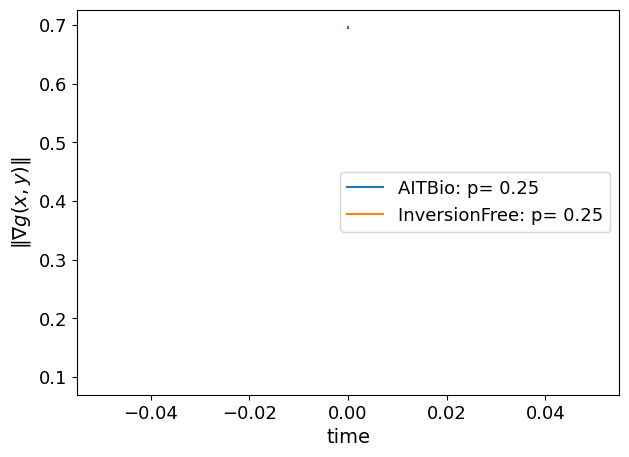

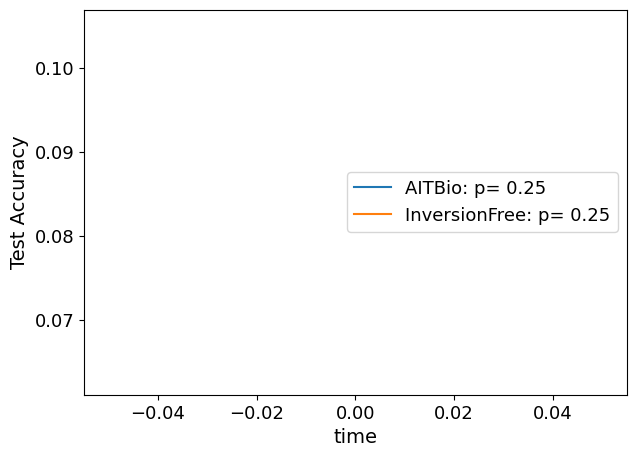

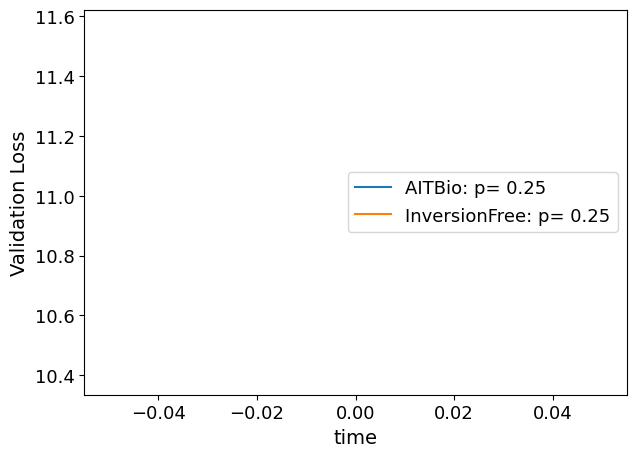

In [39]:
toy_example = False
calc_derivatives = calc_derivatives_analytic
torch.manual_seed(0); np.random.seed(0)
# 
plt.rcParams.update({'font.size': 13})

fig1, ax1 = plt.subplots(1, 1, figsize=(7, 5))
fig11, ax11 = plt.subplots(1, 1, figsize=(7, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(7, 5))
if not toy_example:
    fig3, ax3 = plt.subplots(1, 1, figsize=(7, 5))
    fig4, ax4 = plt.subplots(1, 1, figsize=(7, 5))


scenarioAlpha = [('InversionFree', 0.01, 0.1, None), ('InversionFree', 0.05, 0.1, None), 
                 ('InversionFree', 0.1, 0.1, None), ('InversionFree', 0.5, 0.1, None), 
                 ('InversionFree', 1, 0.1, None)]
scenarioEps = [('InversionFree', 0.1, 0.05, None), ('InversionFree', 0.1, 0.1, None),
                ('InversionFree', 0.1, 0.5, None), ('InversionFree', 0.1, 1, None)]
scenario2nd = [('SecondOrder', 0.1, None, None), ('STABLE', 0.1, None, None)]
scenarioOthers = [('AITBio', 0.1, 0.1, 0.25), ('InversionFree', 0.1, 0.1, 0.25)]
# scenarioOthers = [('InversionFree', 0.1, 0.1, 0.25), ('TTSA', 0.1, 0.1, 0.25)]
# 
scenarioTest = [('InversionFree', 0.1, 0.1, 0.25), ('InversionFree', 0.1, 0.1, 0.5), ('TTSA', 0.1, 0.2, 0.25), ('TTSA', 0.1, 0.2, 0.5) ]
# 
scenarios = scenarioOthers
solutions = []

if toy_example:
    f, g, c, d, A, H, dimX, dimY = load_setup(toy_example)
else:
    f, g, A_tr, B_tr, A_val, B_val, A_test, B_test, dimX, dimY = load_setup(toy_example, p=scenarios[0][3])
sizeX = dimX[0] * dimX[1]; sizeY = dimY[0] * dimY[1]



if toy_example:
    x = torch.randn((sizeX, 1), requires_grad=True, dtype=torch.float32)
    t = torch.linspace(0, 100, 10000)
else:
    x = torch.zeros((sizeX, 1), requires_grad=True, dtype=torch.float32)
    t = torch.linspace(0, 1, 1)

for (method, alpha, epsilon, p) in scenarios:
    print('-- Method:', method, 'Alpha:', alpha, 'Epsilon:', epsilon)

    if not toy_example: f, g, A_tr, B_tr, A_val, solutionB_val, A_test, B_test, dimX, dimY = load_setup(toy_example, p=p)
    # y0, dgdy = solveLL(x)
    y0 = torch.randn((sizeY, 1), requires_grad=True, dtype=torch.float32)
    # -----------------------------------------------------------------
    dxdt = torch.zeros((sizeX, 1))
    t1 = time.time()
    if method in ['InversionFree', 'NewSecondOrder', 'SecondOrder', 'STABLE']:
        initial_conditions = torch.cat((x, y0), 0)
        solution = torchdiffeq.odeint(system, initial_conditions, t, method='rk4')
        tt = t
        lossF, lossG, lossF2 = [], [], []
        train_accuracy, val_accuracy, test_accuracy = [], [], []
        train_loss, val_loss, test_loss = [], [], []
        for i in range(len(solution)):
            lossF.append(f(solution[i, :sizeX], solution[i, sizeX:]).detach().numpy().reshape(-1))
            dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(solution[i, :sizeX], solution[i, sizeX:])
            lossG.append(torch.linalg.norm(dgdy).detach().numpy())
            lossF2.append(torch.linalg.norm(dfdx - dgdyx.T @ dgdyy.inverse() @ dfdy).detach().numpy())
            if not toy_example:
                W = solution[i, sizeX:]
                train_accuracy.append(calculate_accuracy(A_tr, B_tr, W))
                train_loss.append(calculate_loss(A_tr, B_tr, W))
                val_accuracy.append(calculate_accuracy(A_val, B_val, W))
                val_loss.append(calculate_loss(A_val, B_val, W))
                test_accuracy.append(calculate_accuracy(A_test, B_test, W))
                test_loss.append(calculate_loss(A_test, B_test, W))
        acc = (train_accuracy, val_accuracy, test_accuracy); loss = (train_loss, val_loss, test_loss)
    elif method == 'AIDBio':
        lossF, lossG, lossF2, acc, loss = AIDBio(x, y0, K=np.maximum(1, int(len(t) * 4 / 11)), D=10)
        tt = torch.linspace(0, t[-1], lossF.shape[0])
    elif method == 'AITBio':
        lossF, lossG, lossF2, acc, loss = AITBio(x, y0, K=np.maximum(1, int(len(t) * 4 / 11)), D=10)
        tt = torch.linspace(0, t[-1], lossF.shape[0])
    elif method == 'TTSA':
        # y0 = torch.randn((sizeY, 1), requires_grad=True, dtype=torch.float32)
        lossF, lossG, lossF2, acc, loss = TTSA(x, y0, K=np.maximum(1, int(len(t) * 2)))
        tt = torch.linspace(0, t[-1], lossF.shape[0])
    else:
        raise ValueError('Invalid method')
    print('Time taken:', time.time() - t1, '\n')

    
    with torch.no_grad():
        flag_method, flag_alpha, flag_epsilon, flag_p = 1, 1, 1, 1
        try:
            if scenarios[0][0] == scenarios[1][0]: flag_method = 0
            if scenarios[0][1] == scenarios[1][1]: flag_alpha = 0
            if scenarios[0][2] == scenarios[1][2]: flag_epsilon = 0
            if scenarios[0][3] == scenarios[1][3]: flag_p = 0
        except:
            flag_alpha, flag_epsilon, flag_p = 0, 0, 0

        if flag_alpha: strLabel = r': $\alpha$= ' + str(alpha)
        elif flag_epsilon: strLabel = r': $\varepsilon$= ' + str(epsilon)
        elif not toy_example: strLabel = r': p= ' + str(p)
        else: strLabel = ''
        
        ax1.plot(tt, lossF, label= (method + strLabel))
        ax11.plot(tt, lossF2, label=(method + strLabel))
        
        # -----------------------------------------------------
        ax2.plot(tt, lossG, label=(method + strLabel))
        ax2.plot(tt, [epsilon] * len(tt), 'r--')

        if not toy_example: 
            # Plotting accuracy
            print('Train Accuracy:', acc[0][-1].item(), 'Validation Accuracy:', acc[1][-1].item(), 'Test Accuracy:', acc[2][-1].item())
            ax3.plot(t, acc[2], label=(method + strLabel))
            ax3.set_xlabel('time', fontsize=14)
            ax3.set_ylabel('Test Accuracy', fontsize=14)
            ax3.legend()

            # Plotting loss
            # ax2.plot(t, train_loss, label='Train')
            ax4.plot(t, loss[1], label=(method + strLabel))
            ax4.set_xlabel('time', fontsize=14)
            ax4.set_ylabel('Validation Loss', fontsize=14)
            ax4.legend()

            fig3.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + 'Acc' + '.pdf', dpi=300)
            fig4.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + 'Loss' + '.pdf', dpi=300)
        ax1.legend()
        ax1.set_xlabel('time', fontsize=14)
        ax1.set_ylabel('f(x,y)', fontsize=14)

        ax11.legend()
        ax11.set_xlabel('time', fontsize=14)
        ax11.set_ylabel(r'$\|\nabla F(x,y)\|$', fontsize=14)
        ax11.set_yscale('log')

        ax2.legend()
        ax2.set_xlabel('time', fontsize=14)
        ax2.set_ylabel(r'$\|\nabla g(x,y)\|$', fontsize=14)


        # plt.tight_layout()
        scenarioItems = ['method', 'alpha', 'epsilon']
        item = 2 * flag_epsilon + 1 * flag_alpha + 0 * flag_method
        fig1.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-up1' + '.pdf', dpi=300)
        fig11.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-up2' + '.pdf', dpi=300)
        fig2.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-low' + '.pdf', dpi=300)